In [3]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster, 
    RecursiveRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [28]:
raw_data = pd.read_csv('prices.csv')
raw_data.head()

,delivery_start_utc,delivery_end_utc,price
0,21.03.2021 22:00:00,21.03.2021 23:00:00,244.29
1,21.03.2021 21:00:00,21.03.2021 22:00:00,260.00
2,21.03.2021 20:00:00,21.03.2021 21:00:00,265.00
3,21.03.2021 19:00:00,21.03.2021 20:00:00,286.10
4,21.03.2021 18:00:00,21.03.2021 19:00:00,295.79


In [34]:
y = raw_data['price']
dates = pd.to_datetime(raw_data['delivery_start_utc'])
y.index = dates
y = y.sort_index()

y.head()

delivery_start_utc
2010-01-01 00:00:00    129.30
2010-01-01 01:00:00    110.17
2010-01-01 02:00:00    104.46
2010-01-01 03:00:00    105.00
2010-01-01 04:00:00    105.01
Name: price, dtype: float64

In [36]:
N_HOURS = 24
N_DAYS = 30

y_train, y_test = temporal_train_test_split(y, test_size=N_HOURS*N_DAYS)
print(f'y_train shape: {y_train.shape[0]}, y_test_shape: {y_test.shape[0]} ')

y_train shape: 97631, y_test_shape: 720 


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

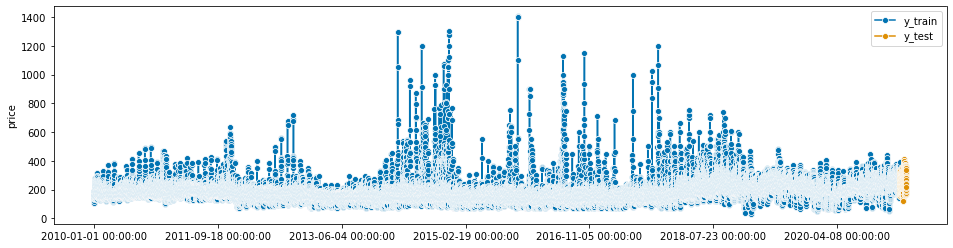

In [37]:
plot_series(y_train, y_test, labels=['y_train', 'y_test'])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

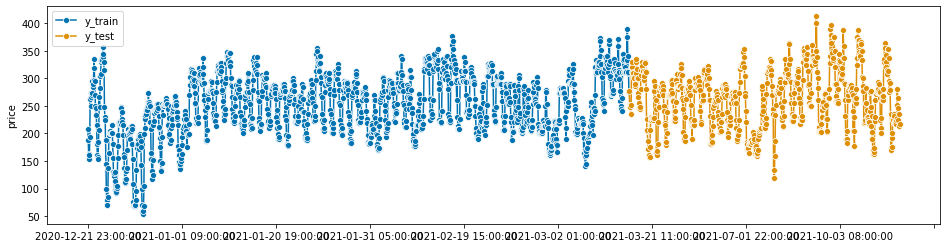

In [42]:
N_MONTHS = 2
plot_series(y_train.iloc[-N_MONTHS*N_DAYS*N_HOURS:], y_test, labels=['y_train', 'y_test'])

In [49]:
TEST_SAMPLE = 24*7

y_train_sample = y_train.iloc[-N_MONTHS*N_DAYS*N_HOURS:]
y_test_sample = y_test.iloc[:TEST_SAMPLE]

In [52]:
forecasting_horizon = y_test_sample.index
forecasting_horizon

DatetimeIndex(['2021-03-18 23:00:00', '2021-03-19 00:00:00',
               '2021-03-19 01:00:00', '2021-03-19 02:00:00',
               '2021-03-19 03:00:00', '2021-03-19 04:00:00',
               '2021-03-19 05:00:00', '2021-03-19 06:00:00',
               '2021-03-19 07:00:00', '2021-03-19 08:00:00',
               ...
               '2021-05-01 14:00:00', '2021-05-01 15:00:00',
               '2021-05-01 16:00:00', '2021-05-01 17:00:00',
               '2021-05-01 18:00:00', '2021-05-01 19:00:00',
               '2021-05-01 20:00:00', '2021-05-01 21:00:00',
               '2021-05-01 22:00:00', '2021-05-01 23:00:00'],
              dtype='datetime64[ns]', name='delivery_start_utc', length=168, freq=None)

In [59]:
naive_forecaster = NaiveForecaster(strategy='last')
naive_forecaster.fit(y_train_sample)
test_samples = y_test_sample.values
y_pred_sample = naive_forecaster.predict(test_samples)
plot_series(y_train_sample, y_test_sample, y_pred_sample, 
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])

TypeError: Unsafe NumPy casting, you must explicitly cast

array([276.4 , 251.  , 248.35, 247.08, 235.36, 250.99, 311.46, 320.  ,
       330.  , 311.46, 309.3 , 309.3 , 301.8 , 299.89, 286.4 , 285.88,
       290.  , 309.31, 330.  , 334.97, 316.88, 300.09, 300.07, 273.94,
       266.6 , 255.09, 245.94, 245.21, 243.68, 247.  , 280.  , 306.6 ,
       315.  , 329.52, 320.  , 322.76, 312.97, 312.75, 305.  , 295.99,
       304.83, 312.75, 329.52, 328.  , 310.52, 279.77, 226.71, 205.  ,
       207.  , 186.  , 172.  , 171.  , 157.  , 160.  , 157.12, 175.8 ,
       206.51, 224.96, 227.07, 229.92, 227.07, 227.07, 227.07, 225.  ,
       227.07, 227.07, 277.79, 295.79, 286.1 , 265.  , 260.  , 244.29,
       163.83, 160.  , 160.  , 167.95, 180.  , 220.  , 247.37, 270.2 ,
       279.58, 282.14, 283.52, 285.  , 281.66, 285.6 , 275.  , 290.43,
       291.  , 285.3 , 277.96, 269.38, 250.  , 241.  , 219.65, 214.73,
       184.47, 178.97, 183.84, 184.75, 200.  , 239.04, 267.01, 269.33,
       269.33, 269.33, 269.33, 270.  , 270.4 , 271.1 , 271.76, 278.4 ,
      

In [57]:
naive_forecaster

NaiveForecaster()